In [1]:
sys.path.append('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/skin-lesion-segmentation-transformer')
from Datasets.create_dataset import norm01, SkinClasDataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import numpy as np
import pandas as pd
import sys
import os
import torchvision
import random
import h5py
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [11]:
data_folder = '/bigdata/siyiplace/data/skin_lesion'
features_list = []
diagnosis_id_dic = {}  # class
dataset_id_list = []  # dataset
d_label_list= []   # dynamic domain label
exp_name = 'N35'
model_name = 'FATNet_dynamic'
# ['isic2018','PH2','DMF','SKD']
for dataset_name in ['isic2018','PH2','DMF','SKD']:
    # hdf_path = data_folder+'/{}/{}_{}_feature_{}.h5'.format(dataset_name,exp_name,model_name,dataset_name)
    hdf_path = data_folder+'/{}/{}_{}_feature_{}.h5'.format(dataset_name, exp_name, model_name,dataset_name)
    with h5py.File(hdf_path, 'r') as f:
        features = np.array(f['feature'])
        diagnosis_ids = list(f['diagnosis_id'])
        d_labels = list(f['d_label'])
        dataset_ids = list(f['dataset_id'])
    f.close()
    features_list.append(features)
    diagnosis_id_dic[dataset_name] = diagnosis_ids
    dataset_id_list.extend(dataset_ids)
    d_label_list.extend(d_labels)

In [12]:
feat_arr = np.concatenate(features_list, axis=0)
feat_arr = PCA(n_components=128).fit_transform(feat_arr)

In [13]:

tsne = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(feat_arr)
# model =  PCA(n_components=2)
# tsne = model.fit_transform(feat_arr)

/ubc/ece/home/ra/grads/siyi/anaconda3/envs/skinlesion/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/ubc/ece/home/ra/grads/siyi/anaconda3/envs/skinlesion/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
# tx = scale_to_01_range(tx)
# ty = scale_to_01_range(ty)

In [1]:
# kmeans update
group_onehot_arr = np.array(dataset_id_list)
new_group_arr = group_onehot_arr
group_onehot_arr = torch.nn.functional.one_hot(torch.from_numpy(group_onehot_arr),4).float().numpy()
p_arr = np.matmul(group_onehot_arr.transpose(), feat_arr)/(np.sum(group_onehot_arr, axis=0, keepdims=True).transpose()+1e-6) # (4,dim)
# print(p_arr)
# print(group_onehot_arr.shape, feat_arr.shape)
shape = {'isic2018':'o','PH2':'v','DMF':'s','SKD':'D'}
color = {'isic2018':'blue','PH2':'orange','DMF':'green','SKD':'red'}

NameError: name 'np' is not defined

In [65]:
# GMM update
# calculate initial weights mean covariance
from sklearn.mixture._gaussian_mixture import _estimate_gaussian_parameters, _compute_precision_cholesky
# for i in range(10):
new_group_arr = group_onehot_arr
# group_onehot_arr = torch.nn.functional.one_hot(torch.from_numpy(group_onehot_arr),4).float().numpy()
init_weights, init_means, init_covariance = _estimate_gaussian_parameters(feat_arr, group_onehot_arr, reg_covar=1e-6, covariance_type='full')
init_weights = init_weights.astype(np.int32)
init_weights = init_weights/np.sum(init_weights)

init_precisions_cholesky = _compute_precision_cholesky(init_covariance, 'full')
# print(init_precisions_cholesky.min(), )
# print(init_means)
print(init_weights)
gm = GaussianMixture(n_components=4, random_state=42, max_iter=100, weights_init=init_weights, means_init=init_means)
gm.precisions_cholesky_ = init_precisions_cholesky
new_group_arr = gm.fit_predict(feat_arr)
p_arr = gm.means_
print(new_group_arr.shape)
# group_onehot_arr =  torch.nn.functional.one_hot(torch.from_numpy(new_group_arr),4).float().numpy()

[0.62796771 0.04677113 0.30151947 0.02374169]
(4212,)


In [17]:
# kmeans
for i in range(10):
    p_arr = np.matmul(group_onehot_arr.transpose(), feat_arr)/(np.sum(group_onehot_arr, axis=0, keepdims=True).transpose()+1e-6) # (4,dim)

    # 2 calculate W weight matrix  (N,4)
    feat_arr_reap = np.repeat(feat_arr[:,:,np.newaxis],4,axis=2).transpose((0,2,1))  # (N,4,dim)
    dynamic_dws = np.linalg.norm(feat_arr_reap-p_arr,axis=2)  # (N,4)
    dynamic_dws = 1-dynamic_dws/(np.sum(dynamic_dws,axis=1,keepdims=True)+1e-6)  # reverse (N,4)
    # softmax
    # dynamic_dws = dynamic_dws-np.max(dynamic_dws,axis=1,keepdims=True)  # (N,4)
    # dynamic_dws = np.exp(dynamic_dws)/np.sum(np.exp(dynamic_dws),axis=1,keepdims=True) # (N,4)

    # 3 update group label
    new_group_arr = np.argmax(dynamic_dws,axis=1)  # (N)
    group_onehot_arr =  torch.nn.functional.one_hot(torch.from_numpy(new_group_arr),4).float().numpy()

In [32]:
# knn
for i in range(200):
    p_arr = np.matmul(group_onehot_arr.transpose(), feat_arr)/(np.sum(group_onehot_arr, axis=0, keepdims=True).transpose()+1e-6)
    knn = KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='auto')
    knn.fit(feat_arr, new_group_arr)
    # distance, k_neighbors = knn.kneighbors(feat_arr)
    # print(distance.shape, k_neighbors.shape)
    # print(distance[0], k_neighbors[0])
    # print(new_group_arr[0])
    # print(new_group_arr[k_neighbors])
    ### Equal weights for all the neighbors
    new_group_arr = knn.predict(feat_arr)
group_onehot_arr =  torch.nn.functional.one_hot(torch.from_numpy(new_group_arr),4).float().numpy()

In [97]:
for i in range(10):
    p_arr = np.matmul(group_onehot_arr.transpose(), feat_arr)/(np.sum(group_onehot_arr, axis=0, keepdims=True).transpose()+1e-6) # (4,dim)

    # 2 calculate W weight matrix  (N,4)
    feat_arr_reap = np.repeat(feat_arr[:,:,np.newaxis],4,axis=2).transpose((0,2,1))  # (N,4,dim)
    dynamic_dws = np.linalg.norm(feat_arr_reap-p_arr,axis=2)  # (N,4)
    dynamic_dws = 1-dynamic_dws/(np.sum(dynamic_dws,axis=1,keepdims=True)+1e-6)  # reverse (N,4)
    # softmax
    # dynamic_dws = dynamic_dws-np.max(dynamic_dws,axis=1,keepdims=True)  # (N,4)
    # dynamic_dws = np.exp(dynamic_dws)/np.sum(np.exp(dynamic_dws),axis=1,keepdims=True) # (N,4)

    # 3 update group label
    new_group_arr = np.argmax(dynamic_dws,axis=1)  # (N)
    group_onehot_arr =  torch.nn.functional.one_hot(torch.from_numpy(new_group_arr),4).float().numpy()

1060
299
1172
1681


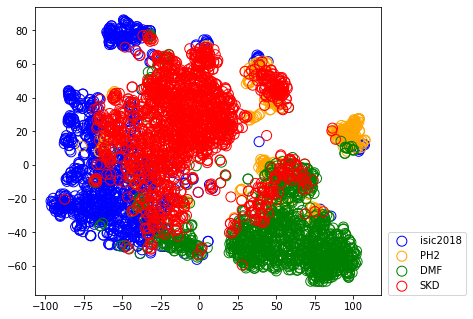

In [18]:
# initialize a matplotlib plot
fig = plt.figure(figsize=(8,5))
ax = plt.axes([0.05,0.05,0.6,0.8])
# prototypes = model.transform(p_arr)

# 'isic2018','PH2','DMF','SKD'
for label_id, dataset_name in enumerate(['isic2018','PH2','DMF','SKD']):
    indices = [i for i, l in enumerate(new_group_arr) if l == label_id]
    print(len(indices))
    data_tx = np.take(tx, indices)
    data_ty = np.take(ty, indices)
    # ax.scatter(data_tx, data_ty, label=dataset_name, s=20,marker=shape[dataset_name],facecolors='none',edgecolors=color[dataset_name])
    if dataset_name in ['isic2018','PH2','DMF','SKD']:
        ax.scatter(data_tx, data_ty, label=dataset_name, s=100, edgecolors=color[dataset_name],facecolors='none')
        # ax.scatter(data_tx.mean(), data_ty.mean(),label=dataset_name,marker=shape[dataset_name],s=100,color='black')
        # ax.scatter(prototypes[label_id][0], prototypes[label_id][1],label=dataset_name,marker=shape[dataset_name],s=100,color='black')
    # ax.plot()
        
# ax.set_title('TSNE {} Visualization for four datasets'.format(model_name))
# build a legend using the labels we set previously
ax.legend(bbox_to_anchor=(1.02,0), loc=3, borderaxespad=0)
# save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/{}_{}_TSNE.jpg'.format('four',model_name)
# plt.savefig(save_path)
# finally, show the plot
plt.show()